### Importing Important Libraries

#### Steps To Be Followed
1. Importing necessary Libraries
2. Creating S3 bucket 
3. Mapping train And Test Data in S3
4. Mapping The path of the models in S3

In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

/Users/sathwik/Downloads/AWS Sagemaker/myenv/lib/python3.8/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/06/25 03:38:22] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/sathwik/Library/Application Support/sagemaker/config.yaml


In [2]:
bucket_name = 'csrtestbucket1' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

[03/06/25 03:45:14] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://csrtestbucket1/xgboost-as-a-built-in-algo/output


#### Downloading The Dataset And Storing in S3

In [5]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


In [6]:
### Train Test split

import numpy as np
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


In [8]:
### Saving Train And Test Into Buckets
## We start with Train Data
from sagemaker.inputs import TrainingInput
import os
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

[03/06/25 03:49:59] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

In [9]:
# Test Data Into Buckets
from sagemaker.inputs import TrainingInput
pd.concat([test_data['y_yes'], test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

[03/06/25 03:51:07] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

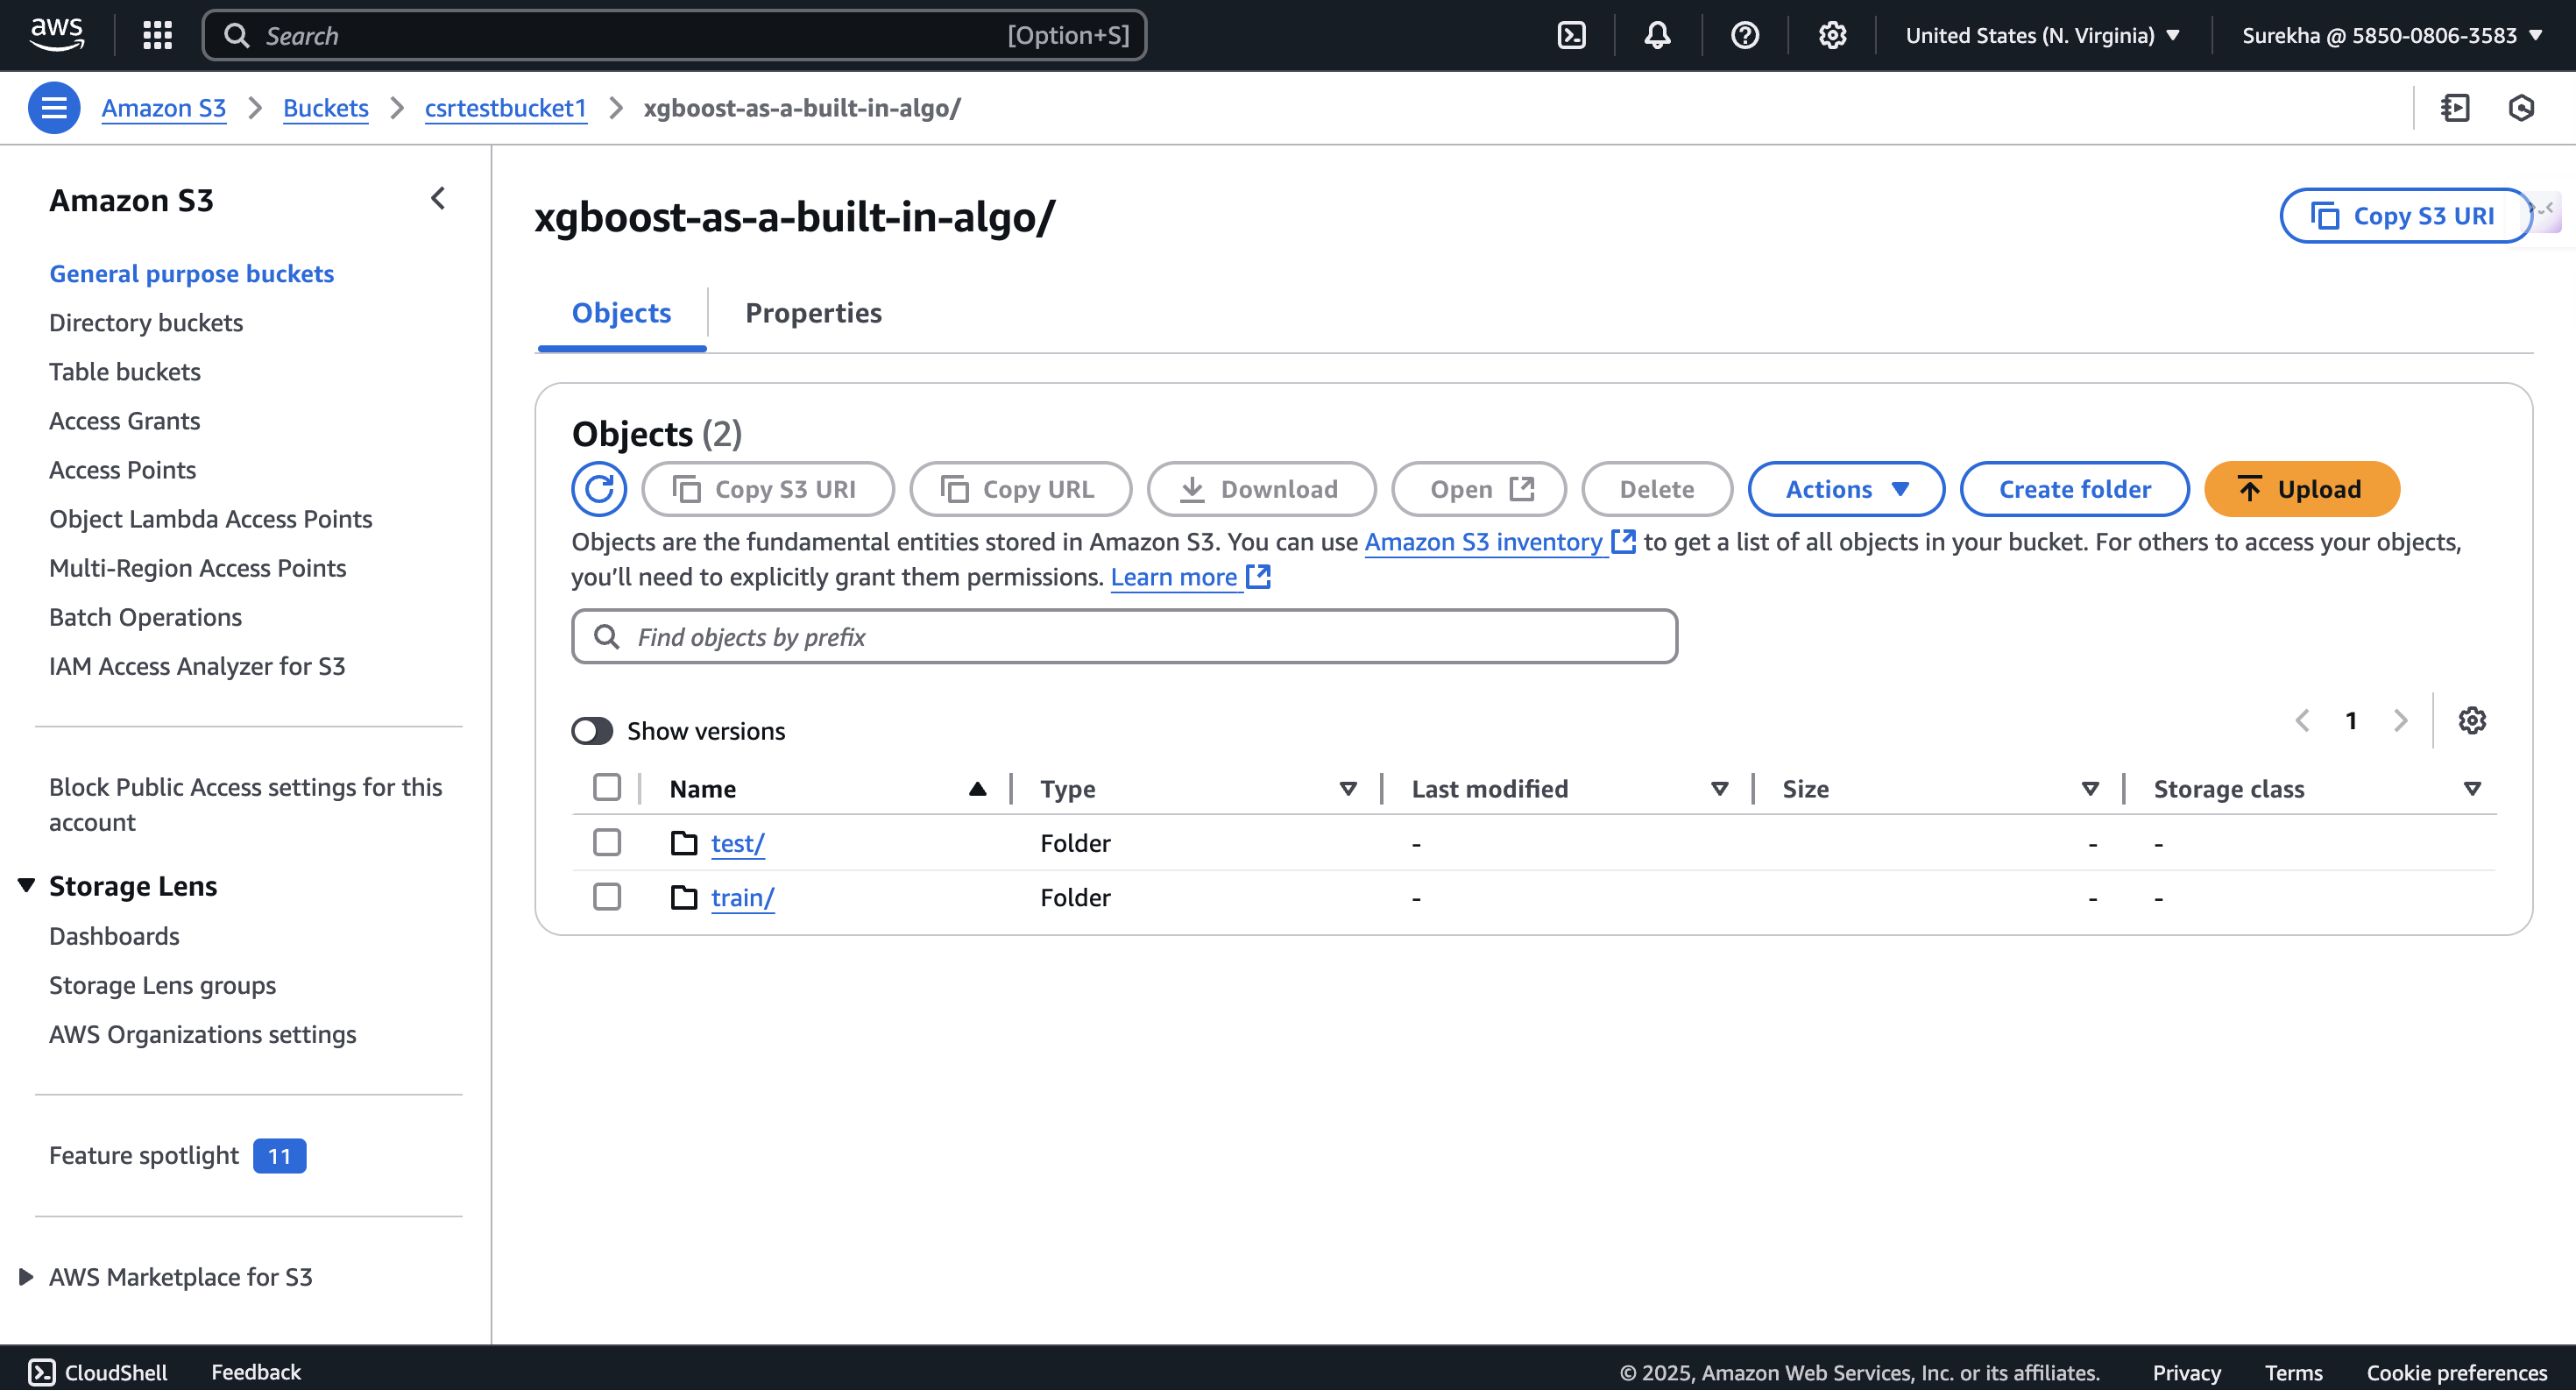

### Building Models Xgboot- Inbuilt Algorithm

In [10]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

[03/06/25 03:51:58] WARNING  The method get_image_uri has been renamed in sagemaker>=2.          deprecations.py:34
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Defaulting to only available Python version: py3                     image_uris.py:610

                    INFO     Defaulting to only supported image scope: cpu.                       image_uris.py:534

In [11]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

In [22]:
import sagemaker

role = "arn:aws:iam::585008063583:role/MySageMakerRole"

estimator = sagemaker.estimator.Estimator(
    image_uri=container, 
    role=role,  
    instance_count=1, 
    instance_type="ml.m5.large",  # Ensure this instance type is available
    hyperparameters=hyperparameters,
    output_path=output_path,
    use_spot_instances=True,
    max_run=300,
    max_wait=600
)


In [23]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

[03/06/25 04:10:24] INFO     SageMaker Python SDK will collect telemetry to help us better  telemetry_logging.py:91
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       session.py:1042
                             sagemaker-xgboost-2025-03-06-09-10-24-262                                             

2025-03-06 09:10:24 Starting - Starting the training job...
2025-03-06 09:10:45 Starting - Preparing the instances for training...
2025-03-06 09:11:06 Downloading - Downloading input data...
2025-03-06 09:11:52 Downloading - Downloading the training image......
2025-03-06 09:12:53 Training - Training image download completed. Training in progress.
2025-03-06 09:12:53 Uploading - Uploading generated training model[2025-03-06 09:12:47.699 ip-10-0-250-64.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:ro

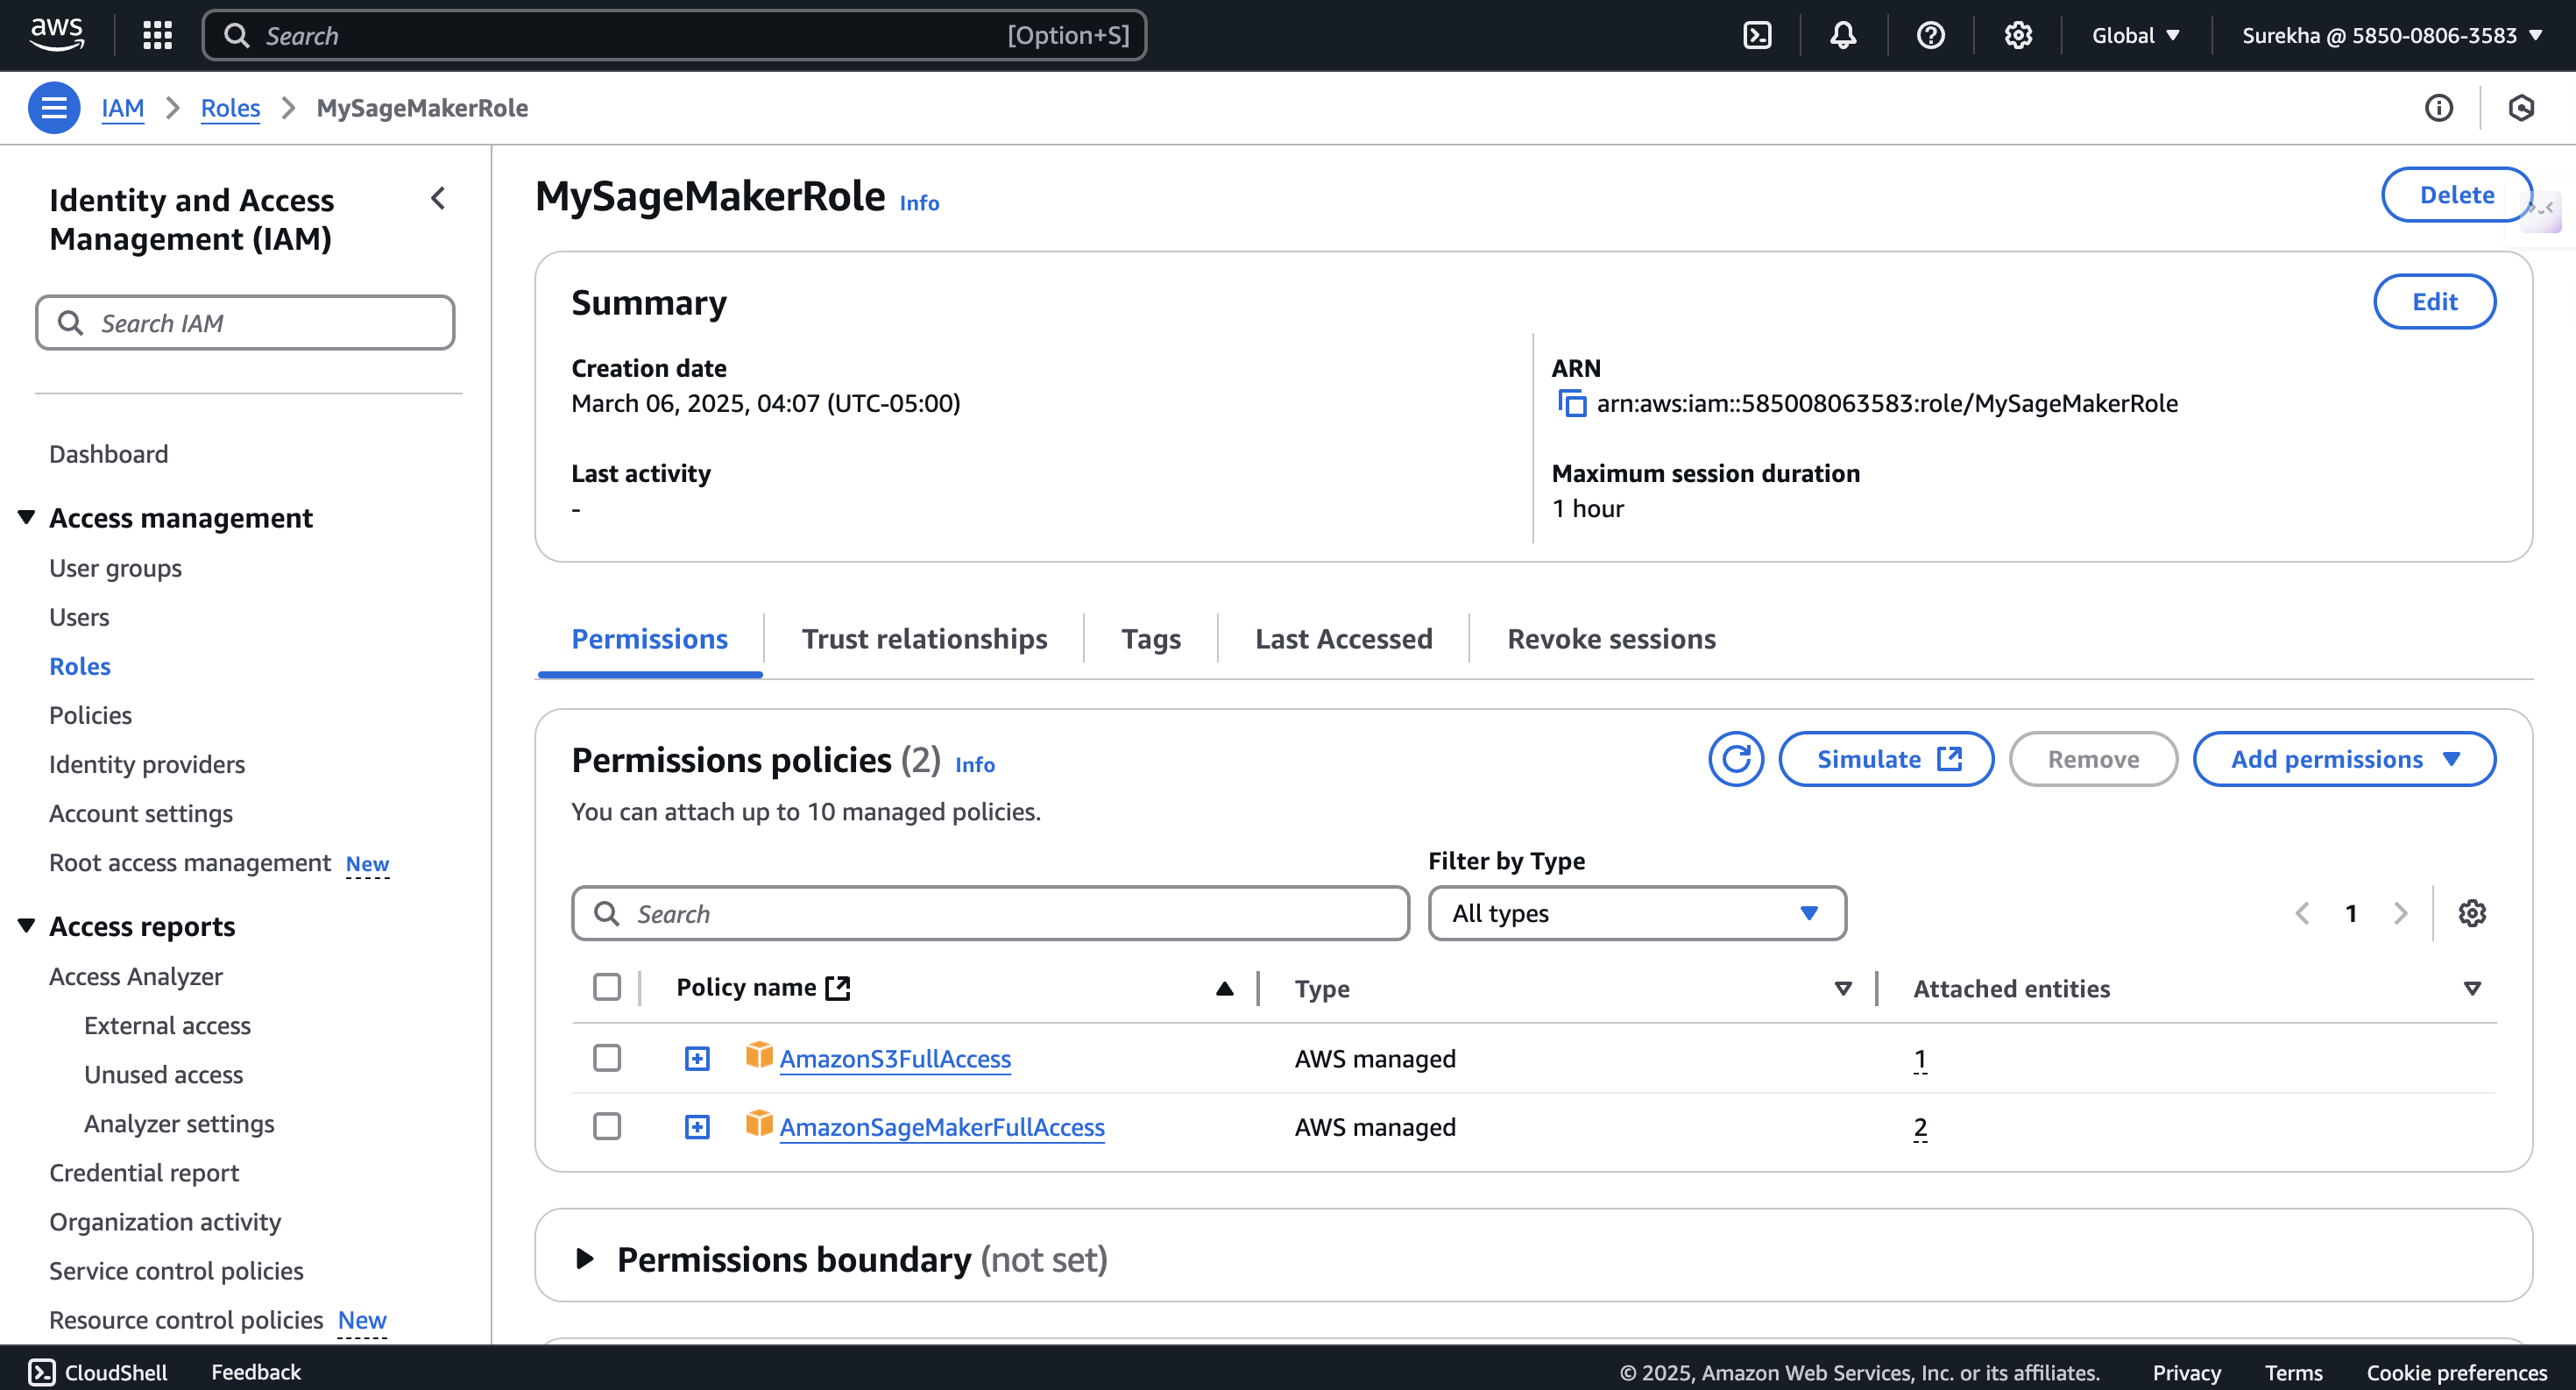

### Deploy Machine Learning Model As Endpoints

In [24]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

[03/06/25 04:14:25] INFO     Creating model with name: sagemaker-xgboost-2025-03-06-09-14-25-681    session.py:4094

[03/06/25 04:14:26] INFO     Creating endpoint-config with name                                     session.py:5937
                             sagemaker-xgboost-2025-03-06-09-14-25-681                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-03-06-09-14-25-681  session.py:4759

------!

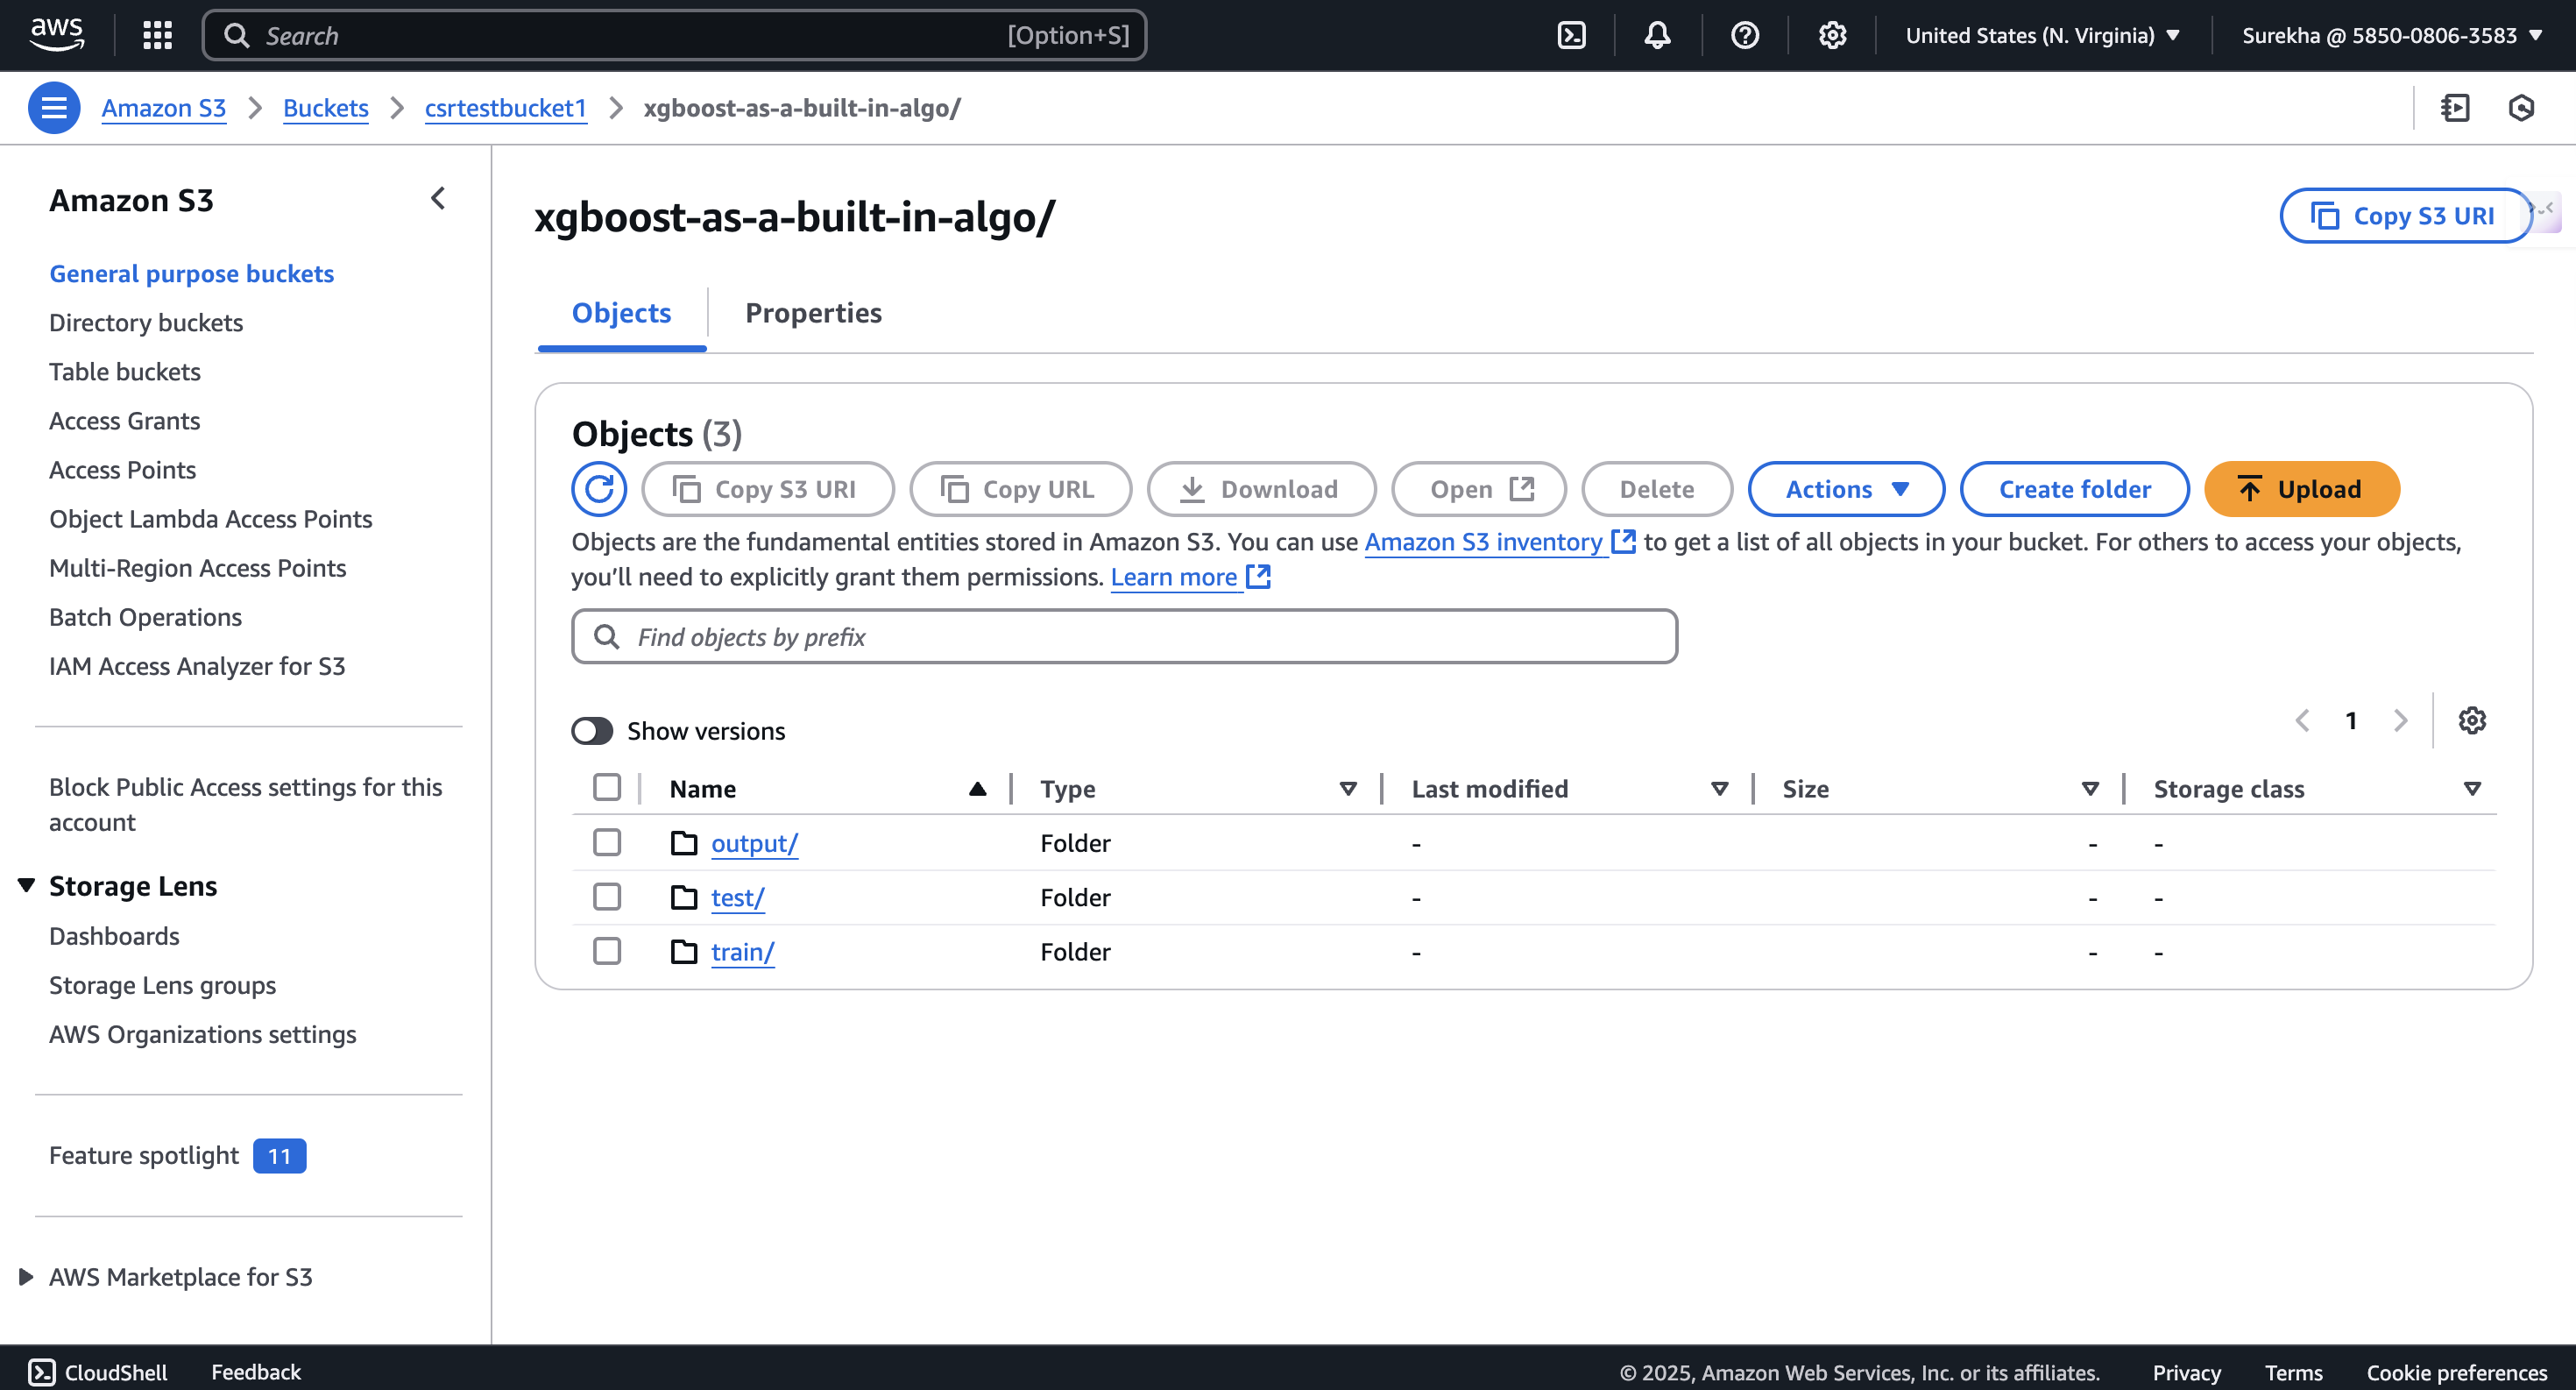

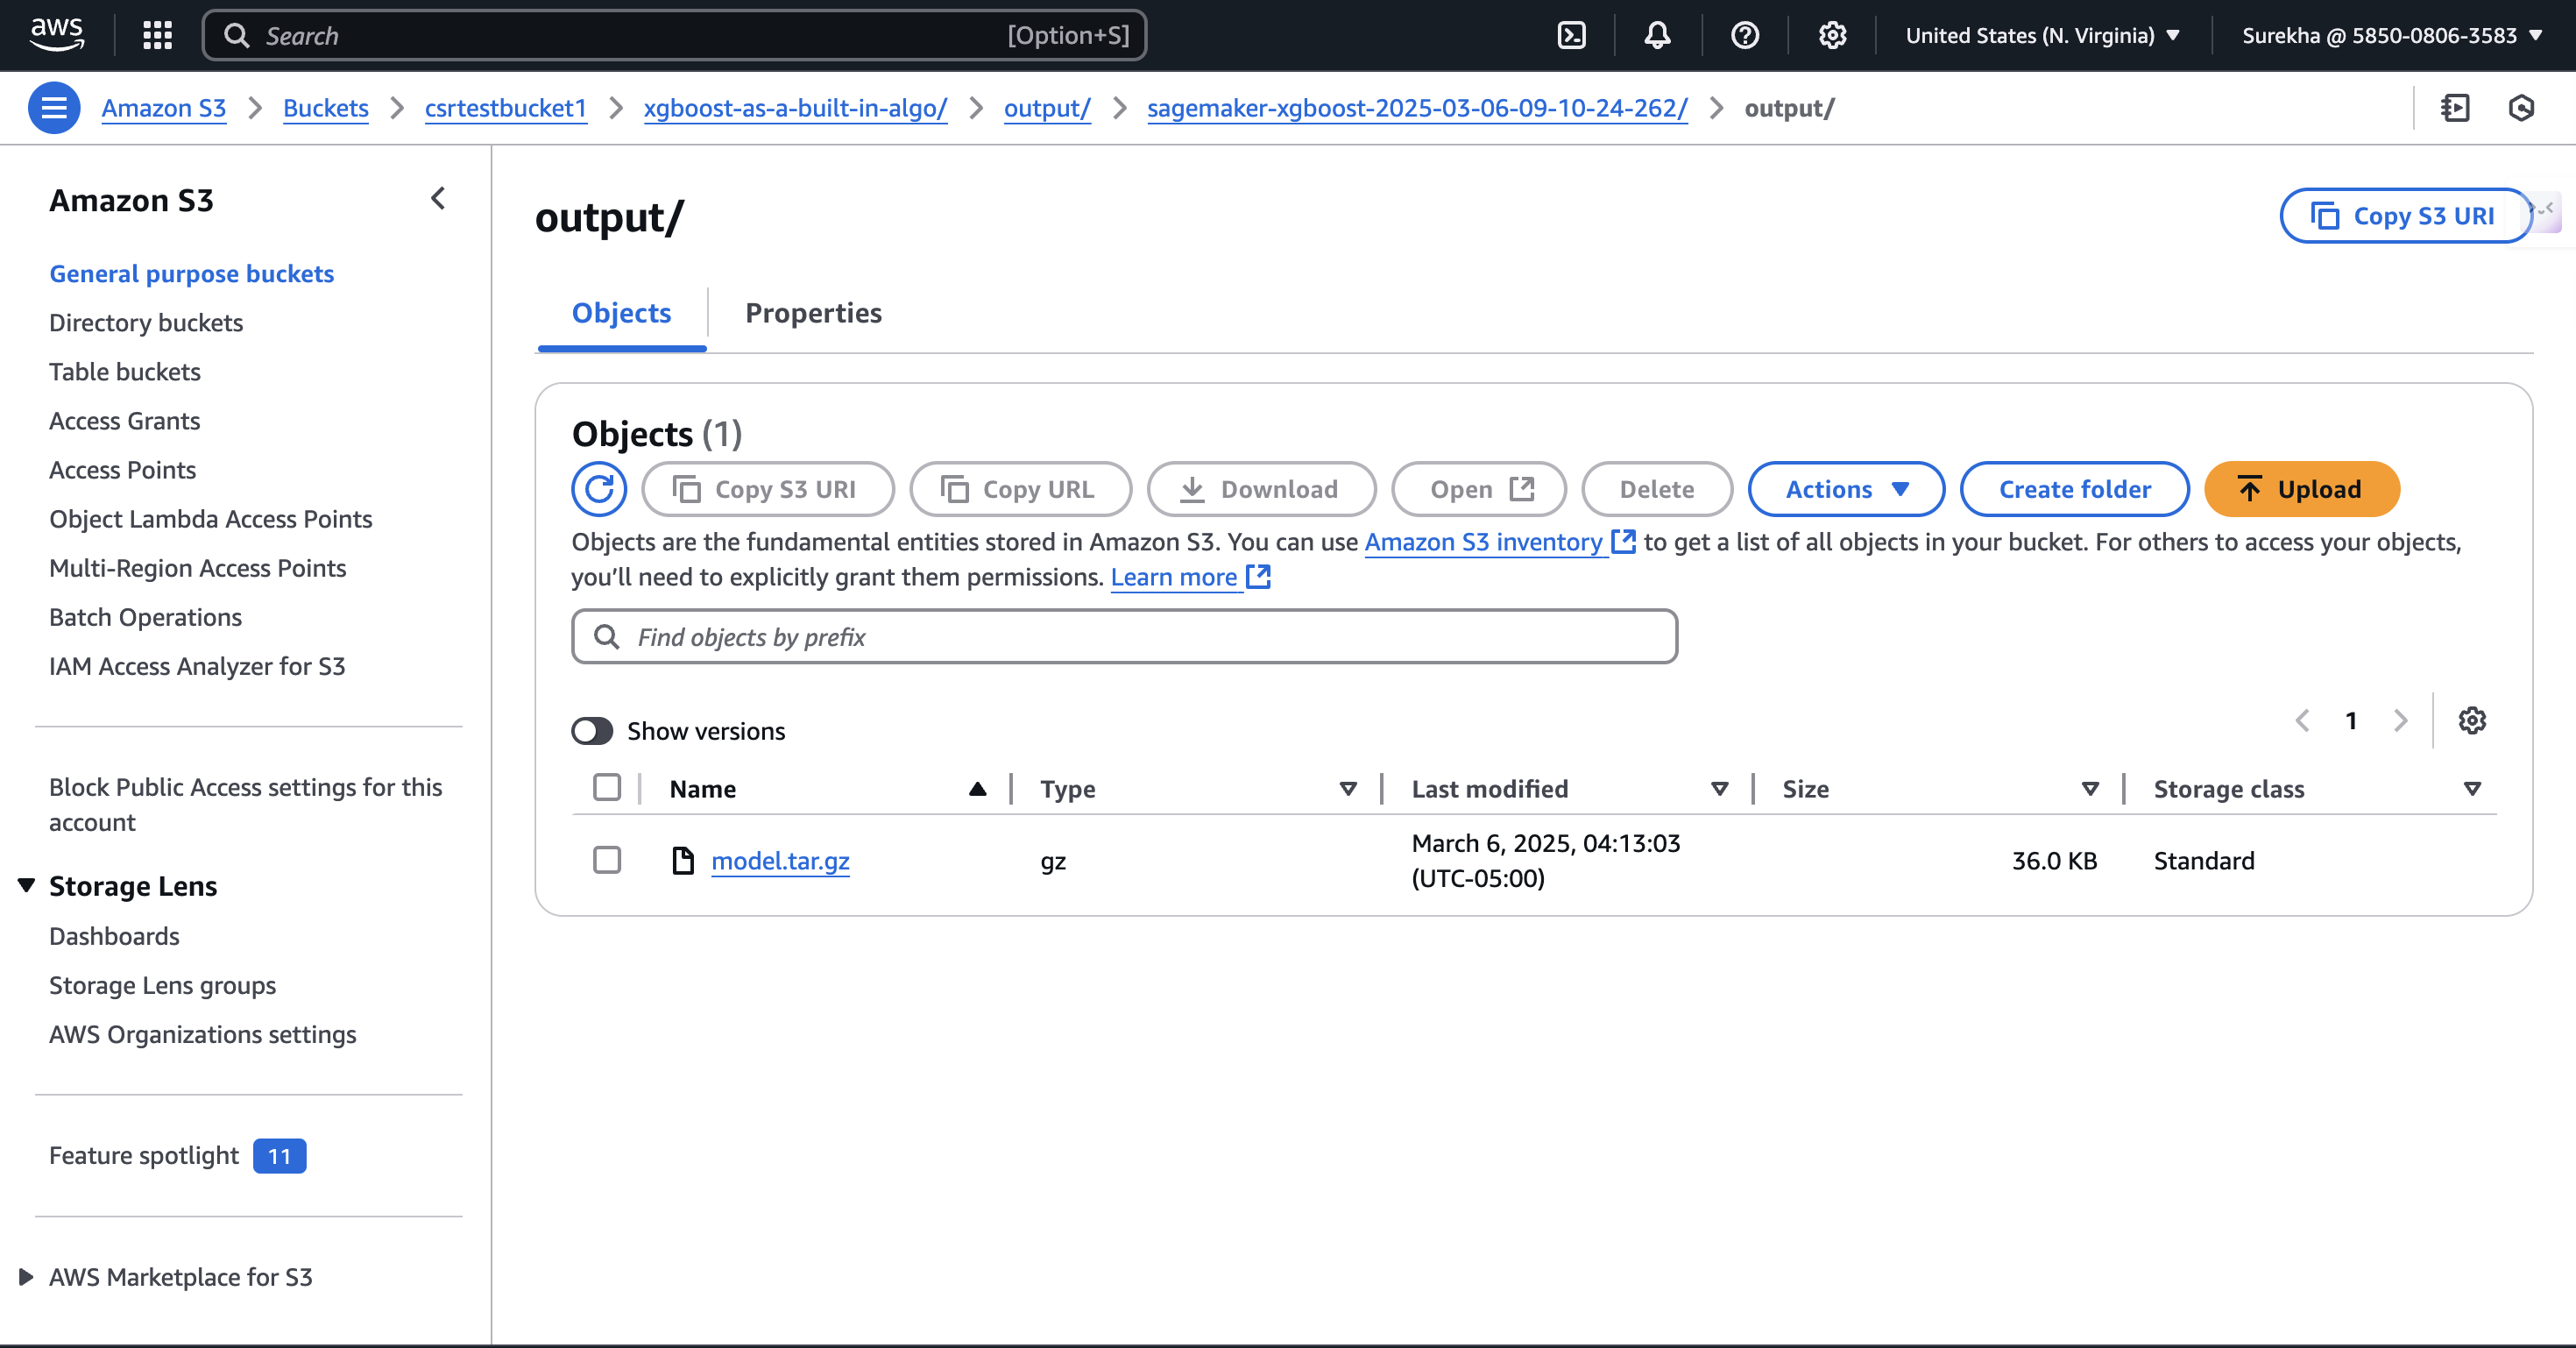

#### Prediction of the Test Data

In [26]:
from sagemaker.serializers import CSVSerializer

test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values  # load the data into an array
xgb_predictor.content_type = 'text/csv'  # set the data type for an inference
xgb_predictor.serializer = CSVSerializer()  # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8')  # predict!
predictions_array = np.fromstring(predictions[1:], sep=',')  # turn the prediction into an array
print(predictions_array.shape)


(12357,)


In [27]:
predictions_array

array([0.05214286, 0.05660191, 0.05096195, ..., 0.03436061, 0.02942475,
       0.03715819])

In [28]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.7%

Predicted      No Purchase    Purchase
Observed
No Purchase    91% (10785)    34% (151)
Purchase        9% (1124)     66% (297) 



#### Deleting The Endpoints

In [29]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[03/06/25 04:22:46] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            deprecations.py:34
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-03-06-09-14-25-681 session.py:4903

[{'ResponseMetadata': {'RequestId': 'NNBPYJK7CSV158MX',
   'HostId': 'lv5wR5PL8gYneAq/1voKq7NIM2z5hZrx4it6QHsLV3wCY+/M5FbdIAoM5cfCpZfaCLDsISawD5s=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'lv5wR5PL8gYneAq/1voKq7NIM2z5hZrx4it6QHsLV3wCY+/M5FbdIAoM5cfCpZfaCLDsISawD5s=',
    'x-amz-request-id': 'NNBPYJK7CSV158MX',
    'date': 'Thu, 06 Mar 2025 09:22:48 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2025-03-06-09-10-24-262/debug-output/index/000000000/000000000010_worker_0.json',
    'DeleteMarker': True,
    'DeleteMarkerVersionId': 'CzeTpmPAcYwq2l3OZ5xrDjAVNqWytp4z'},
   {'Key': 'xgboost-as-a-built-in-algo/train/train.csv',
    'DeleteMarker': True,
    'DeleteMarkerVersionId': 'IhipNlvTVFcgErhE8duFAgM8s.7y46kq'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2025-03-